# Kaggle 1등 수상자 코드 따라 하기 : 연습


- 전처리를 하고
- 

In [ ]:
# 모듈 불러 오기
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import numpy as np
import pandas as pd
from collections import Counter
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import math

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"

In [ ]:
# 데이터 로드 및 원본 보존
df_raw = pd.read_csv(f"{data_path}/4-1.labeledTrainData.tsv",
                     header=0,
                     delimiter='\t',
                     quoting=3)
display(df_raw)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."


## _1_. MI로 전처리

In [ ]:
def clean_text(x):
    x = BeautifulSoup(x, 'lxml').get_text() # HTML 태그 제거
    x = re.sub("[^a-zA-Z]", " ", x) # 영어 제외 바꾸기
    x = x.lower() # 소문자
    x = [w for w in x.split() if not w in stopwords.words('english')] # 불용어 제거
    x = [PorterStemmer().stem(word) for word in x] # 포터 스테밍으로 어간 추출
    return " ".join(x)

In [ ]:
%%time
df_raw['text'] = df_raw['review'].apply(lambda x: clean_text(x))

CPU times: user 12min 1s, sys: 1min 33s, total: 13min 34s
Wall time: 13min 34s


In [ ]:
df = df_raw[['text', 'sentiment']]
display(df)

,text,sentiment
0,stuff go moment mj start listen music watch od...,1
1,classic war world timothi hine entertain film ...,1
2,film start manag nichola bell give welcom inve...,0
3,must assum prais film greatest film opera ever...,0
4,superbl trashi wondrous unpretenti exploit hoo...,1
...,...,...
24995,seem like consider gone imdb review film went ...,0
24996,believ made film complet unnecessari first fil...,0
24997,guy loser get girl need build pick stronger su...,0
24998,minut documentari bu uel made earli one spain ...,0


In [ ]:
# 긍정 sentiment와 부정 sentiment로 나누기
df_pos = df[df['sentiment'] == 1]
df_neg = df[df['sentiment'] == 0]

### 어휘집 생성 : MI Score 계산

- `counter` 방식 맞는지 확인

In [ ]:
def build_vocab(df):
    vocabulary = Counter()

    for text in df['text']:
        for word in list(set(word_tokenize(text))): # set으로 중복 단어 제거
            vocabulary[word] += 1
    
    return vocabulary.most_common()

In [ ]:
def calc_MI(pos_df, neg_df):
    # p_pos = len(pos_df) / (len(pos_df) + len(neg_df))
    # p_neg = len(neg_df) / (len(pos_df) + len(neg_df))
    # print(p_pos, p_neg)

    pos_vocab = build_vocab(pos_df)
    neg_vocab = build_vocab(neg_df)
    
    merge_vocab = {}
    for k, v in pos_vocab:
        merge_vocab[k] = [v, 0]
    for k, v in neg_vocab:
        if k in merge_vocab:
            merge_vocab[k][1] = v
        else:
            merge_vocab[k] = [0, v]
    
    # MI 계산
    clip = 0.00001
    for k, v in merge_vocab.items():
        merge_vocab[k] = (v[0] / (len(pos_df)+len(neg_df))) * math.log(2*(v[0]+clip) / (v[0] + v[1])) + \
                        (v[1] / (len(pos_df)+len(neg_df))) * math.log(2*(v[1]+clip) / (v[0] + v[1]))
        
        # (v[0]/len(pos_df))*math.log(2*v[1]+clip) p_pos + (v[1]/len(neg_df))*p_neg
    
    return {k:v for k, v in sorted(merge_vocab.items(), key=lambda x:x[1], reverse=True)}

In [ ]:
# 어휘집 생성
%%time
vocabulary = calc_MI(df_pos, df_neg)
print(f"총 어휘집 크기: {len(vocabulary)}")

총 어휘집 크기: 50593
CPU times: user 15.2 s, sys: 13.8 ms, total: 15.2 s
Wall time: 15.2 s


In [ ]:
vocabulary

{'worst': 0.03339672032355955,
 'bad': 0.02995543207821568,
 'wast': 0.02796825828945893,
 'aw': 0.020949513844008817,
 'excel': 0.015118278042150645,
 'great': 0.014746135424544643,
 'stupid': 0.013869341659531813,
 'bore': 0.013385185313236781,
 'terribl': 0.013286143910168663,
 'wors': 0.012386798292232949,
 'horribl': 0.011811368745767863,
 'beauti': 0.010777013712436563,
 'love': 0.01035834919201328,
 'perfect': 0.009930598493729927,
 'poor': 0.009799472588613316,
 'crap': 0.00961415156191962,
 'noth': 0.009108241585861643,
 'poorli': 0.008798093907597618,
 'suppos': 0.008438723877403865,
 'lame': 0.008402308462911805,
 'best': 0.008264126411535982,
 'ridicul': 0.007907758762736413,
 'favorit': 0.007839851348527879,
 'minut': 0.007728080352910172,
 'pointless': 0.007347289875913286,
 'laughabl': 0.00679236137487629,
 'perform': 0.0066954196790511185,
 'plot': 0.006626132449258186,
 'superb': 0.006454256989843573,
 'annoy': 0.006407078268777346,
 'dull': 0.006400577647083301,
 'ama

In [ ]:
# 상위 50퍼센트만 남기기 + OOV 버리기
word2idx = {k:i+1 for i, (k, v) in enumerate(vocabulary.items()) if i <= len(vocabulary)//2}
# word2idx['OOV'] = 0
idx2word = {v:k for k, v in word2idx.items()}

In [ ]:
word2idx

{'worst': 1,
 'bad': 2,
 'wast': 3,
 'aw': 4,
 'excel': 5,
 'great': 6,
 'stupid': 7,
 'bore': 8,
 'terribl': 9,
 'wors': 10,
 'horribl': 11,
 'beauti': 12,
 'love': 13,
 'perfect': 14,
 'poor': 15,
 'crap': 16,
 'noth': 17,
 'poorli': 18,
 'suppos': 19,
 'lame': 20,
 'best': 21,
 'ridicul': 22,
 'favorit': 23,
 'minut': 24,
 'pointless': 25,
 'laughabl': 26,
 'perform': 27,
 'plot': 28,
 'superb': 29,
 'annoy': 30,
 'dull': 31,
 'amaz': 32,
 'money': 33,
 'script': 34,
 'badli': 35,
 'mess': 36,
 'brilliant': 37,
 'oh': 38,
 'highli': 39,
 'enjoy': 40,
 'fantast': 41,
 'fail': 42,
 'suck': 43,
 'pathet': 44,
 'avoid': 45,
 'touch': 46,
 'today': 47,
 'cheap': 48,
 'act': 49,
 'unless': 50,
 'delight': 51,
 'even': 52,
 'embarrass': 53,
 'redeem': 54,
 'save': 55,
 'heart': 56,
 'garbag': 57,
 'instead': 58,
 'unfunni': 59,
 'also': 60,
 'alway': 61,
 'clich': 62,
 'bother': 63,
 'insult': 64,
 'disappoint': 65,
 'least': 66,
 'decent': 67,
 'terrif': 68,
 'excus': 69,
 'recommend': 70

### 시퀀스 토큰화

In [ ]:
# 토크나이징
print(f"기존 문장 개수: {len(df['text'])}")

tokens = []

for idx, text in enumerate(df['text']):
    temp = []
    delete_indices = []

    for word in text.split():
        try:
            temp.append(word2idx[word])
        except KeyError: # OOV
            continue 
    
    if len(temp) > 0:
        tokens.append(temp)
    else:
        delete_indices.append(idx)

print(f"OOV 없는 문장으로만 남긴 개수: {len(tokens)}")
print(f"삭제해야 할 문장 인덱스: {delete_indices}")

기존 문장 개수: 25000
OOV 없는 문장으로만 남긴 개수: 25000
삭제해야 할 문장 인덱스: []


### 패딩

In [ ]:
# 문장 길이 체크
def check_len(threshold, sentences):
    cnt = 0
    for sent in sentences:
        if len(sent) <= threshold:
            cnt += 1
    
    return f'전체 문장 중 길이가 {threshold} 이하인 샘플의 비율: {(cnt/len(sentences))*100}'

for i in range(10, 300, 10):
    print(check_len(i, tokens))

전체 문장 중 길이가 10 이하인 샘플의 비율: 0.132
전체 문장 중 길이가 20 이하인 샘플의 비율: 2.084
전체 문장 중 길이가 30 이하인 샘플의 비율: 6.672000000000001
전체 문장 중 길이가 40 이하인 샘플의 비율: 11.856
전체 문장 중 길이가 50 이하인 샘플의 비율: 22.567999999999998
전체 문장 중 길이가 60 이하인 샘플의 비율: 37.303999999999995
전체 문장 중 길이가 70 이하인 샘플의 비율: 48.46
전체 문장 중 길이가 80 이하인 샘플의 비율: 56.912
전체 문장 중 길이가 90 이하인 샘플의 비율: 63.188
전체 문장 중 길이가 100 이하인 샘플의 비율: 68.328
전체 문장 중 길이가 110 이하인 샘플의 비율: 72.432
전체 문장 중 길이가 120 이하인 샘플의 비율: 75.976
전체 문장 중 길이가 130 이하인 샘플의 비율: 78.996
전체 문장 중 길이가 140 이하인 샘플의 비율: 81.636
전체 문장 중 길이가 150 이하인 샘플의 비율: 83.804
전체 문장 중 길이가 160 이하인 샘플의 비율: 85.804
전체 문장 중 길이가 170 이하인 샘플의 비율: 87.508
전체 문장 중 길이가 180 이하인 샘플의 비율: 88.872
전체 문장 중 길이가 190 이하인 샘플의 비율: 90.13600000000001
전체 문장 중 길이가 200 이하인 샘플의 비율: 91.316
전체 문장 중 길이가 210 이하인 샘플의 비율: 92.32000000000001
전체 문장 중 길이가 220 이하인 샘플의 비율: 93.244
전체 문장 중 길이가 230 이하인 샘플의 비율: 93.988
전체 문장 중 길이가 240 이하인 샘플의 비율: 94.692
전체 문장 중 길이가 250 이하인 샘플의 비율: 95.204
전체 문장 중 길이가 260 이하인 샘플의 비율: 95.776
전체 문장 중 길이가 270 이하인 샘플의 비율: 96.22
전체 문장 중 길이가

In [ ]:
# 문장 패딩
# MAX_LENGTH = int(input('문장 최대 길이 설정: '))
MAX_LENGTH = 200

X_train = pad_sequences(tokens, 
                        maxlen=MAX_LENGTH,
                        padding='post',
                        truncating='post')

X_train = np.array(X_train)
print(f"패딩 후 train data: {X_train.shape}")

패딩 후 train data: (25000, 200)


In [ ]:
# 문장 확인
print(X_train[0])
print(f"샘플 문장 길이: {len(X_train[0])}")

[ 1848   405  1232  1862   600   358   730  9191   623   730   730  1941
   291   277   743  1230  3309   102 15403   715   291   501 15947   335
  1941  8890  8587  8890  4602  9003   439   405  1528   636  1541   556
   132  1994  1862  1349  6389    60   332  1994  6289     2 15371   573
   531  1045  1908  8808    50   157   472  1862  1178   405   677   527
     8   415   389  1862 13527   501   202  1862  1991   213   233   610
  1991    99   715   676   228  4602  9003   526  1986   600    24   748
  2378 15220  1916 15296   160  6289  3683   277  1862   750     2  1837
  1862  4905  1916 15296  5067   277  3846  8726  6289  9160  3275   291
   677  1862   358  5823   197   472  1862  6183  2693  8898   363 15251
 13643 15220    60  1784  3230 14260  8592  4911  9003     2 15220 14021
  1784   677   622  2304   387   363   103    27   164  1402  1616   327
   681   202  3846   472  1862  3806  1422  3846  2799  3971    71  8034
  9186  1994  5825  1862  9908   202  8424  1908  8

### 데이터 저장

In [ ]:
# 라벨 가져오기
y_train = df['sentiment']
y_train = np.array(y_train)
print(f"train label: {y_train.shape}")

train label: (25000,)


In [ ]:
# 전처리 완료된 데이터 저장
input_out_path = f"{data_path}/popcorn_input_mydata.npy"
label_out_path = f"{data_path}/popcorn_label_mydata.npy"

np.save(open(input_out_path, 'wb'), X_train)
np.save(open(label_out_path, 'wb'), y_train)

In [ ]:
df.to_csv(f"{data_path}/popcorn_clean_mydata.csv", index=False, encoding='utf-8-sig')

#### [테스트] 중간에 그냥 LSTM, CNN 해보기

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 32)      809536      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 200, 32)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 198, 64)      6208        dropout_2[0][0]                  
_______________________________________________________________________________________

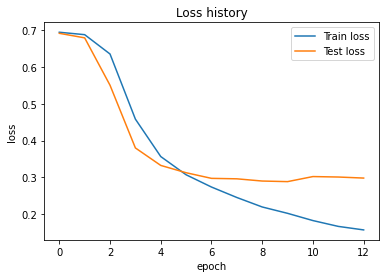


Accuracy = 87.76 %
WnRocAuc Score = 0.8780


In [ ]:
# 트레인 테스트 스플릿
TEST_SPLIT = 0.1
RANDOM_SEED = 42

train_input, test_input, train_label, test_label = train_test_split(X_train, y_train, 
                                                                    test_size=TEST_SPLIT, 
                                                                    random_state=RANDOM_SEED)
# CNN 모델을 빌드한다.
VOCAB_SIZE = X_train.max() + 1
EMB_SIZE = 32
NUM_FILTER = 64

inputX = Input(batch_shape=(None, train_input.shape[1]))
emb = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(inputX)
emb = Dropout(rate=0.5)(emb)
conv1 = Conv1D(filters=NUM_FILTER, kernel_size=3, activation='relu')(emb)
pool1 = GlobalMaxPool1D()(conv1)

conv2 = Conv1D(filters=NUM_FILTER, kernel_size=4, activation='relu')(emb)
pool2 = GlobalMaxPool1D()(conv2)

conv3 = Conv1D(filters=NUM_FILTER, kernel_size=5, activation='relu')(emb)
pool3 = GlobalMaxPool1D()(conv3)
concat = Concatenate()([pool1, pool2, pool3])

hidden = Dense(64, activation='relu')(concat)
hidden = Dropout(rate=0.5)(hidden)
outputY = Dense(1, activation='sigmoid')(hidden)

model = Model(inputX, outputY)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005))
model.summary()

# 학습
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
hist = model.fit(train_input, train_label,
                 validation_data = (test_input, test_label),
                 batch_size = 500, 
                 epochs = 30,
                 callbacks=[es])

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
predicted = model.predict(test_input)
test_pred = np.where(predicted > 0.5, 1, 0)
accuracy = (test_label.reshape(-1, 1) == test_pred).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))
print("WnRocAuc Score = %.4f" % (roc_auc_score(test_label, test_pred)))

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 200, 10)           252980    
_________________________________________________________________
dropout_10 (Dropout)         (None, 200, 10)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 253,941
Trainable params: 253,941
Non-trainable params: 0
________________________________________________

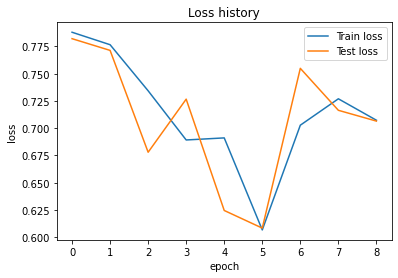


Accuracy = 56.40 %


In [ ]:
# 학습 데이터와 시험 데이터로 분리한다.
TEST_SPLIT = 0.1
RANDOM_SEED = 13371447

train_input, test_input, train_label, test_label = train_test_split(X_train, y_train, 
                                                                    test_size=TEST_SPLIT, random_state=RANDOM_SEED)

# LSTM 모델을 빌드한다.
VOCAB_SIZE = X_train.max() + 1
EMBEDDING_DIM = 10
HIDDEN_DIM = 10
FEATURE_DIM = 10

input_layer = Input(batch_shape=(None, train_input.shape[1]))
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(input_layer)
embedding_layer = Dropout(rate=0.2)(embedding_layer)
rnn_layers = LSTM(HIDDEN_DIM)(embedding_layer)
hidden_layer = Dense(FEATURE_DIM, activation='relu', kernel_regularizer=regularizers.l2(0.01))(rnn_layers)
output_layer = Dense(1, activation='sigmoid')(hidden_layer)

model = Model(input_layer, output_layer)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005))
model.summary()

# 학습
train_label = train_label.reshape(-1, 1)
test_label = test_label.reshape(-1, 1)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
hist = model.fit(train_input, train_label,
                 validation_data = (test_input, test_label),
                 batch_size = 500, 
                 epochs = 500,
                 callbacks=[es])

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
predicted = model.predict(test_input)
test_pred = np.where(predicted > 0.5, 1, 0)
accuracy = (test_label == test_pred).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [ ]:
# 원래 문장으로 바꾸기
sequences = []
for vec in X_train:
    temp = []
    for x in vec:
        try:
            temp.append(idx2word[x])
        except KeyError:
            pass

    sequences.append(temp)

## _2_. TF-IDF

In [ ]:
idx2word

{1: 'worst',
 2: 'bad',
 3: 'wast',
 4: 'aw',
 5: 'excel',
 6: 'great',
 7: 'stupid',
 8: 'bore',
 9: 'terribl',
 10: 'wors',
 11: 'horribl',
 12: 'beauti',
 13: 'love',
 14: 'perfect',
 15: 'poor',
 16: 'crap',
 17: 'noth',
 18: 'poorli',
 19: 'suppos',
 20: 'lame',
 21: 'best',
 22: 'ridicul',
 23: 'favorit',
 24: 'minut',
 25: 'pointless',
 26: 'laughabl',
 27: 'perform',
 28: 'plot',
 29: 'superb',
 30: 'annoy',
 31: 'dull',
 32: 'amaz',
 33: 'money',
 34: 'script',
 35: 'badli',
 36: 'mess',
 37: 'brilliant',
 38: 'oh',
 39: 'highli',
 40: 'enjoy',
 41: 'fantast',
 42: 'fail',
 43: 'suck',
 44: 'pathet',
 45: 'avoid',
 46: 'touch',
 47: 'today',
 48: 'cheap',
 49: 'act',
 50: 'unless',
 51: 'delight',
 52: 'even',
 53: 'embarrass',
 54: 'redeem',
 55: 'save',
 56: 'heart',
 57: 'garbag',
 58: 'instead',
 59: 'unfunni',
 60: 'also',
 61: 'alway',
 62: 'clich',
 63: 'bother',
 64: 'insult',
 65: 'disappoint',
 66: 'least',
 67: 'decent',
 68: 'terrif',
 69: 'excus',
 70: 'recommend'

In [ ]:
corpus = [" ".join(sequence) for sequence in sequences ] # 
print(corpus[:3])

['stuff go moment mj start music watch odd documentari watch watch moonwalk mayb want get certain insight guy thought realli mayb make mind innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward also obviou messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut smooth crimin sequenc joe pesci power drug lord want mj dead bad beyond mj nah joe pesci rant want peopl know drug etc dunno mayb hate mj music lot thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film bad sequenc usual director hate work kid let whole bunch perform complex danc scene bottom line movi peopl like mj anoth think peopl stay away tri give wholesom messag iron mj bestest movi girl michael jackson truli talent peopl ever well attent gave hmmm well know peopl dif

In [ ]:
vectorizer = TfidfVectorizer().fit(corpus)
tfidf_mat = vectorizer.transform(corpus).toarray()
print(type(tfidf_mat), tfidf_mat.shape)
print(vectorizer.vocabulary_)

<class 'numpy.ndarray'> (25000, 24530)
{'stuff': 20757, 'go': 8564, 'moment': 14165, 'mj': 14085, 'start': 20473, 'music': 14497, 'watch': 23610, 'odd': 15277, 'documentari': 5799, 'moonwalk': 14243, 'mayb': 13424, 'want': 23553, 'get': 8348, 'certain': 3484, 'insight': 10551, 'guy': 9049, 'thought': 21667, 'realli': 17537, 'make': 13043, 'mind': 13948, 'innoc': 10522, 'part': 15897, 'biographi': 2104, 'featur': 7263, 'film': 7427, 'rememb': 17779, 'see': 19031, 'cinema': 3886, 'origin': 15486, 'releas': 17755, 'subtl': 20829, 'messag': 13768, 'feel': 7282, 'toward': 22022, 'also': 534, 'obviou': 15249, 'drug': 6058, 'bad': 1445, 'kay': 11376, 'visual': 23377, 'impress': 10330, 'cours': 4590, 'michael': 13830, 'jackson': 10834, 'unless': 22776, 'remot': 17791, 'like': 12410, 'anyway': 844, 'hate': 9362, 'find': 7459, 'bore': 2472, 'may': 13421, 'call': 3089, 'consent': 4377, 'movi': 14363, 'fan': 7130, 'would': 24102, 'say': 18767, 'made': 12940, 'true': 22244, 'nice': 14898, 'actual':

## _3_. Doc2Vec

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sequences)]
doc_model = Doc2Vec(vector_size=300, 
                    alpha=0.025, 
                    min_alpha=0.00025,
                    min_count=10, 
                    workers=4, 
                    dm=1)
doc_model.build_vocab(documents)
doc_model.train(documents, total_examples=doc_model.corpus_count, epochs=10)

In [ ]:
# 모델 확인
keys = list(doc_model.wv.vocab.keys())
print(f"단어 개수: {len(keys)}")
print("========= 샘플 확인 =========")
print(keys[:20])

단어 개수: 8372
========= 샘플 확인 =========
['stuff', 'go', 'moment', 'mj', 'start', 'music', 'watch', 'odd', 'documentari', 'moonwalk', 'mayb', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'realli', 'make', 'mind']


In [ ]:
doc_model.docvecs

In [ ]:
doc_vecs = doc_model.docvecs[:]
print(doc_vecs.shape)

TypeError: ignored